You will need to replace the paths to the /yolov5 folder and path to the `coords_rsna_improved.csv` dataframe

In [1]:
import os
import time
import pandas as pd
from tqdm import tqdm
import torch
import cv2
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
from PIL import Image

### 1. Check coords_rsna_improved.csv

In [2]:
coords_rsna_improved = pd.read_csv("/path/to/coords_rsna_improved.csv")

st2_coordinates = coords_rsna_improved[
    (coords_rsna_improved["condition"] == "Spinal Canal Stenosis") &
    (coords_rsna_improved["side"] == "R")
]

st2_coordinates.head()



,Unnamed: 0,series_id,relative_x,relative_y,condition,side,instance_number,study_id,level
21,21,370109,0.564182,0.282331,Spinal Canal Stenosis,R,9,1217477368,L1/L2
23,23,370109,0.546010,0.413573,Spinal Canal Stenosis,R,9,1217477368,L2/L3
25,25,370109,0.528847,0.536739,Spinal Canal Stenosis,R,9,1217477368,L3/L4
27,27,370109,0.541972,0.633656,Spinal Canal Stenosis,R,9,1217477368,L4/L5
29,29,370109,0.557115,0.732592,Spinal Canal Stenosis,R,9,1217477368,L5/S1


       Unnamed: 0   series_id  relative_x  relative_y              condition  \
49903       49903  3666319702    0.629427    0.289216  Spinal Canal Stenosis   
49905       49905  3666319702    0.616894    0.412210  Spinal Canal Stenosis   
49907       49907  3666319702    0.606867    0.503119  Spinal Canal Stenosis   
49909       49909  3666319702    0.629427    0.601159  Spinal Canal Stenosis   
49911       49911  3666319702    0.674548    0.686720  Spinal Canal Stenosis   

      side  instance_number  study_id  level  
49903    R               10   4646740  L1/L2  
49905    R               10   4646740  L2/L3  
49907    R                9   4646740  L3/L4  
49909    R               10   4646740  L4/L5  
49911    R               11   4646740  L5/S1  


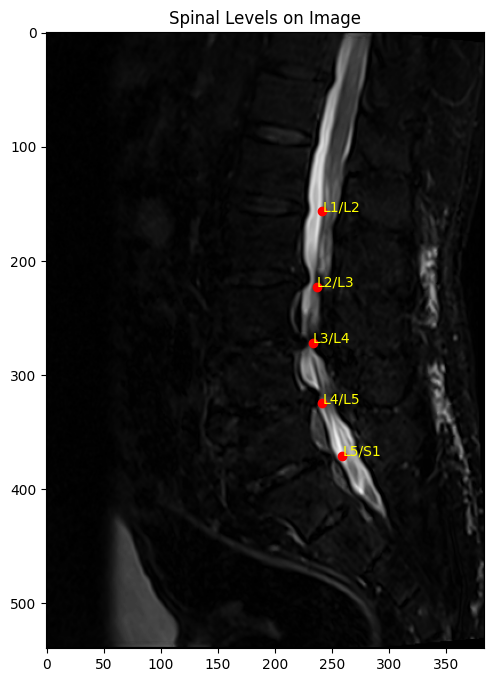

In [3]:
# Load the image corresponding to the instance number (assuming 9th image)
df = st2_coordinates[st2_coordinates["study_id"] == 4646740]

print(df.head())

image_path = '/Data/RSNA/cvt_png/4646740/Sagittal T2_STIR/010.png'
image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')

# Plot the points
for index, row in df.iterrows():
    plt.scatter(row['relative_x'] * image.width, row['relative_y'] * image.height, color='red')
    plt.text(row['relative_x'] * image.width, row['relative_y'] * image.height, row['level'], color='yellow')

plt.title('Spinal Levels on Image')
plt.show()


### 2. Create a yolov5s dataset for sagittal T2 images

In [4]:
yolo_ds_path = "/path/to/yolov5/yolov5-ds"

#Getting the train and valid datasets
study_ids = st2_coordinates['study_id'].unique()
valid_size = 3
study_ids_first_half = study_ids[:-valid_size]
study_ids_second_half = study_ids[-valid_size:]
df_train = st2_coordinates[st2_coordinates['study_id'].isin(study_ids_first_half)]
df_valid = st2_coordinates[st2_coordinates['study_id'].isin(study_ids_second_half)]

In [5]:

def create_dataset(df, train_or_valid):
    study_grouped_df = df.groupby("study_id")

    for study_id, group in tqdm(study_grouped_df):
        group_sorted = group.sort_values(by='instance_number').reset_index(drop=True)
        middle_index = len(group_sorted) // 2
        middle_slice = group_sorted.iloc[middle_index]

        middle_slice_path = f"/Data/RSNA/cvt_png/{study_id}/Sagittal T2_STIR/{middle_slice['instance_number']:03d}.png"
        image = Image.open(middle_slice_path)
        image = image.resize((512,512))

        image.save(f"{yolo_ds_path}/{train_or_valid}/images/{study_id}_{middle_slice['instance_number']:03d}.png")

        coords_txt_path = f"{yolo_ds_path}/{train_or_valid}/labels/{study_id}_{middle_slice['instance_number']:03d}.txt"

        #Improve size of the box
        size = 0.15

        with open(coords_txt_path, "w") as f:
            i = 0
            for _, row in group.iterrows():
                f.write(f"{i} {row['relative_x']} {row['relative_y']} {size} {size}\n")
                i+=1


In [6]:
create_dataset(df_train, "train")
create_dataset(df_valid, "valid")

  0%|          | 0/1971 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 36.35it/s]


### 3. Train the model

Go into /path/to/yolov5/yolov5 and launch python train.py --img 512 --batch 16 --epochs 10 --data path/to/yolov5-ds/data.yaml --weights yolov5s.pt

### 4. Sanity check on validation dataset

In [9]:
def load_model(conf=0.5, iou=0.50):
    model = torch.hub.load(repo_or_dir="/path/to/yolov5/yolov5",
                           model='custom',
                           path="/path/to/yolov5/yolov5/runs/train/exp5/weights/best.pt",
                           source='local',
                           force_reload=True)  
    model.conf = conf  
    model.iou  = iou  
    model.classes = None   
    model.multi_label = False 
    model.max_det = 5
    model.eval()
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")
    return model

model_box = load_model()

def get_yolo_predictions(img):
    img = np.stack((img,) * 3, axis=-1)
    results = model_box(img, size=512)
    return results.pandas().xyxy[0]

YOLOv5 🚀 v7.0-365-g12b577c8 Python-3.9.18 torch-2.3.1+cu118 CUDA:0 (NVIDIA RTX A4000, 16080MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


  0%|          | 0/3 [00:00<?, ?it/s]

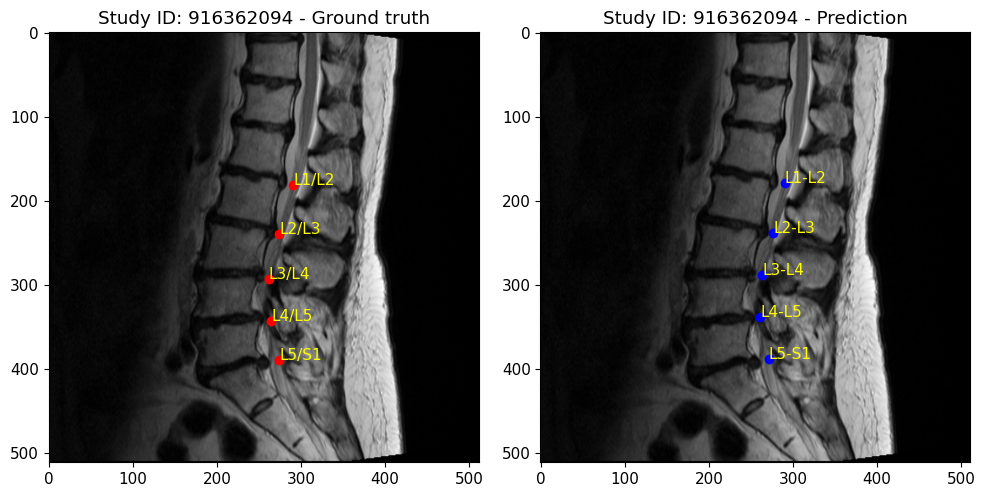

 33%|███▎      | 1/3 [00:00<00:00,  5.05it/s]

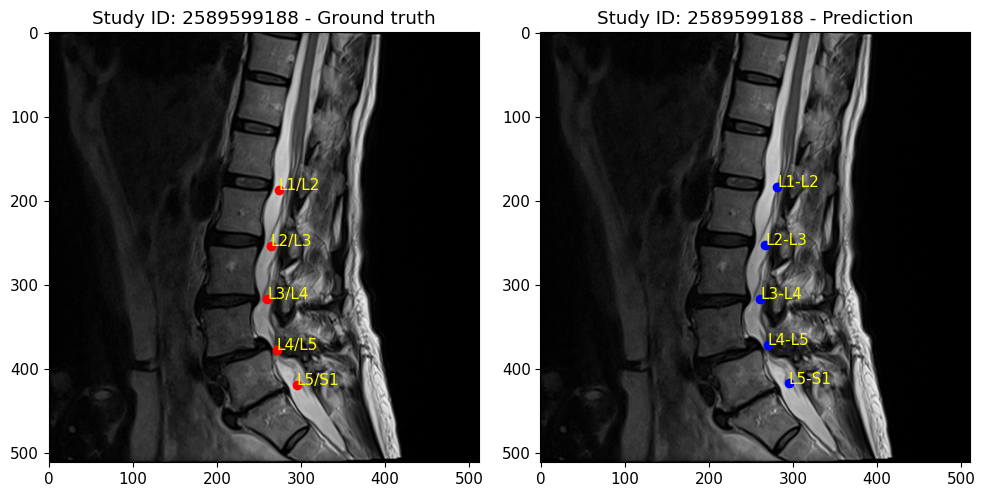

 67%|██████▋   | 2/3 [00:00<00:00,  5.28it/s]

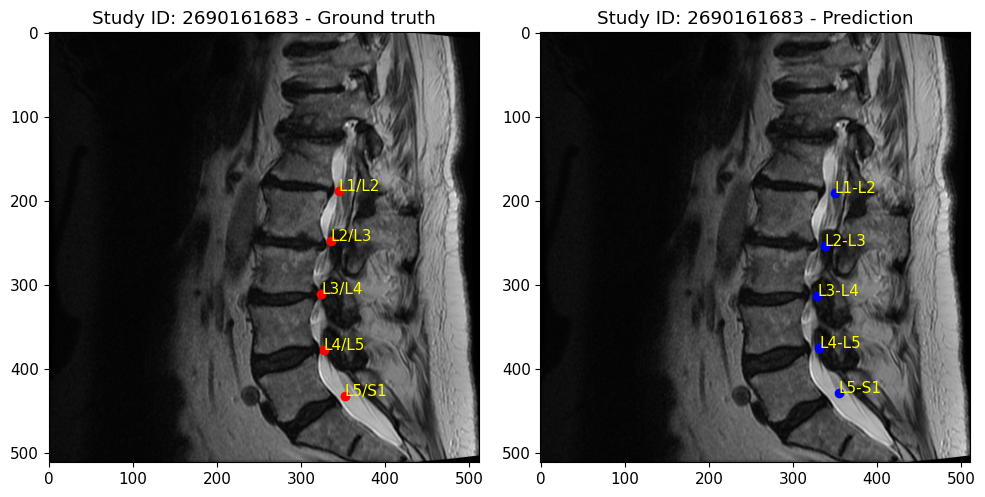

100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


In [12]:
%matplotlib inline

from itertools import islice
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

study_grouped_df = df_valid.groupby("study_id")

for study_id, group in tqdm(study_grouped_df):
    group_sorted = group.sort_values(by='instance_number').reset_index(drop=True)
    middle_index = len(group_sorted) // 2
    middle_slice = group_sorted.iloc[middle_index]

    middle_slice_path = f"/path/to/cvt_png/{study_id}/Sagittal T2_STIR/{middle_slice['instance_number']:03d}.png"
    image = Image.open(middle_slice_path)
    image = image.resize((512, 512))

    preds = get_yolo_predictions(image)
    
    # Create a figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot with red dots
    axes[0].imshow(image, cmap='gray')
    for index, row in group.iterrows():
        axes[0].scatter(row['relative_x'] * image.width, row['relative_y'] * image.height, color='red')
        axes[0].text(row['relative_x'] * image.width, row['relative_y'] * image.height, row['level'], color='yellow')
    axes[0].set_title(f"Study ID: {study_id} - Ground truth")
    
    # Plot with blue dots
    axes[1].imshow(image, cmap='gray')
    for idx, row in preds.iterrows():
        axes[1].scatter(.5*(row["xmin"] + row["xmax"]), .5*(row["ymin"] + row["ymax"]), color="blue")
        axes[1].text(.5*(row["xmin"] + row["xmax"]), .5*(row["ymin"] + row["ymax"]), row["name"], color='yellow')
    axes[1].set_title(f"Study ID: {study_id} - Prediction")
    
    plt.tight_layout()
    plt.show()
